---
title: "Multi-label Classification of Amazonian Land Space"
description: |
  Project
author:
  - name: Jake Gehri
    url: {}
date: "2022-10-19"
categories: ["Python", "Deep Learning", "Computer Vision"]
image: amazon.jpg
format: 
  html:
    df-print: paged
    toc: true
engine: knitr
---

In [ ]:
import pandoc
from fastbook import *
from fastai import *

In [2]:
creds = '{"username":"jakegehri","key":"3d0213a52bd1816d21037e941bc77569"}'

In [3]:
# Creates a cred path for kaggle datasets to be downloaded in comand line

cred_path = Path('~/.kaggle/kaggle.json').expanduser() 

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [139]:
path = Path('./planet/planet')

In [140]:
path.ls()

(#4) [Path('planet/planet/train_classes.csv'),Path('planet/planet/test-jpg'),Path('planet/planet/sample_submission.csv'),Path('planet/planet/train-jpg')]

In [6]:
train = (path/'train-jpg').ls()

In [7]:
train

(#40479) [Path('planet/planet/train-jpg/train_19921.jpg'),Path('planet/planet/train-jpg/train_24619.jpg'),Path('planet/planet/train-jpg/train_21510.jpg'),Path('planet/planet/train-jpg/train_31089.jpg'),Path('planet/planet/train-jpg/train_33277.jpg'),Path('planet/planet/train-jpg/train_11172.jpg'),Path('planet/planet/train-jpg/train_14671.jpg'),Path('planet/planet/train-jpg/train_29521.jpg'),Path('planet/planet/train-jpg/train_27535.jpg'),Path('planet/planet/train-jpg/train_13323.jpg')...]

In [8]:
data = (path/'train_classes.csv')

In [9]:
df = pd.read_csv(data)

In [10]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
dblock = DataBlock()

In [12]:
dsets = dblock.datasets(df)

In [13]:
dsets[0]

(image_name         train_0
 tags          haze primary
 Name: 0, dtype: object,
 image_name         train_0
 tags          haze primary
 Name: 0, dtype: object)

In [14]:
def get_x(r): return path/'train-jpg'/(r['image_name'] + '.jpg')
def get_y(r): return r['tags'].split(' ')

In [15]:
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('planet/planet/train-jpg/train_1398.jpg'),
 ['agriculture', 'partly_cloudy', 'primary', 'road'])

In [16]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   get_x=get_x, get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.]))

In [17]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, get_y=get_y)

dsets = dblock.datasets(df)

In [18]:
len(dsets.train), len(dsets.valid)

(32384, 8095)

In [19]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35)
                  
)

dls = dblock.dataloaders(df)

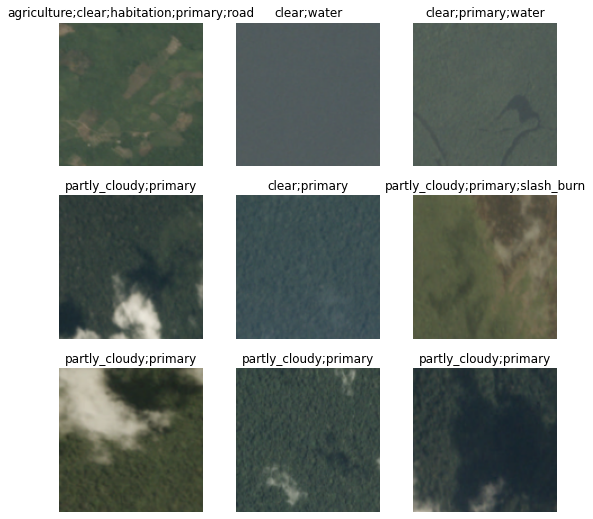

In [20]:
dls.show_batch()

# Experiment 1

In [25]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi)
learn.fine_tune(6, freeze_epochs=2)
learn.recorder.plot_loss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.242502,0.150174,0.945827,00:25
1,0.147816,0.126972,0.951968,00:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.127971,0.109930,0.957991,00:23
1,0.119986,0.104264,0.960476,00:23
2,0.109712,0.098336,0.962301,00:38
3,0.104570,0.097734,0.962555,00:49


# Experiment 2

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.244604,0.147677,0.947447,00:51
1,0.148016,0.123402,0.953312,00:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.123248,0.106454,0.959452,00:59
1,0.118266,0.104211,0.960942,00:34
2,0.111732,0.098766,0.962381,00:42
3,0.105815,0.096162,0.963245,00:34
4,0.099851,0.094583,0.964037,00:34
5,0.093574,0.095035,0.963848,00:34


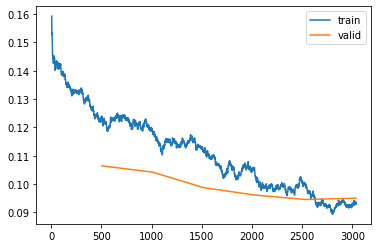

In [277]:
learn2 = vision_learner(dls, resnet34, metrics=accuracy_multi)
learn2.fine_tune(6, freeze_epochs=2)
learn2.recorder.plot_loss()

# Experiment 3

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.240184,0.151341,0.934862,00:38
1,0.151022,0.122403,0.939382,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.124375,0.106883,0.950107,00:35
1,0.118021,0.101975,0.951757,00:34
2,0.109789,0.099863,0.952055,00:34
3,0.104578,0.096811,0.951851,00:34
4,0.095859,0.095459,0.953784,00:34
5,0.092178,0.095330,0.954445,01:02


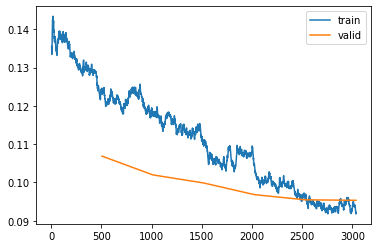

In [270]:
learn3 = vision_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))
learn3.fine_tune(6, freeze_epochs=2)
learn3.recorder.plot_loss()

# Experiment 4

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.248779,0.148406,0.942892,00:52
1,0.147272,0.123920,0.950325,00:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.125626,0.109230,0.955863,00:48
1,0.118446,0.103957,0.956015,00:34
2,0.112594,0.099723,0.958754,00:37
3,0.106374,0.096328,0.958689,00:51
4,0.099089,0.094283,0.960499,00:34
5,0.095276,0.094695,0.961879,00:39


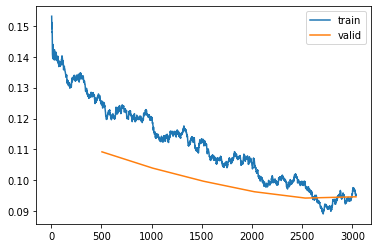

In [275]:
learn4 = vision_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.7))
learn4.fine_tune(6, freeze_epochs=2)
learn4.recorder.plot_loss()

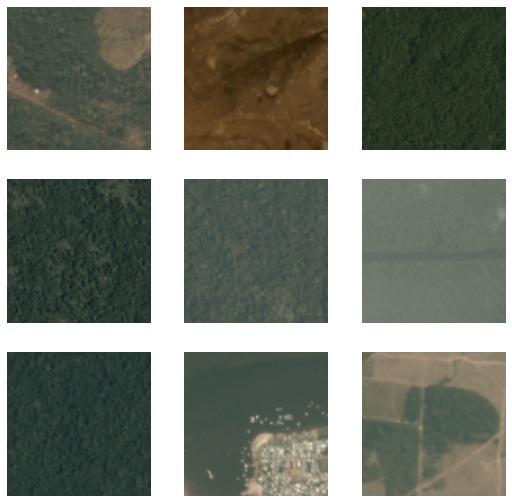

In [278]:
test_dl = learn2.dls.test_dl(get_image_files(path/'test-jpg'))
test_dl.show_batch()

In [279]:
preds, _ = learn2.get_preds(dl=test_dl)

In [280]:
thresh = 0.5
labelled_preds = [' '.join([learn2.dls.vocab[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [281]:
labelled_preds[:5]

['agriculture clear primary road',
 'bare_ground clear',
 'clear primary',
 'clear primary',
 'clear primary']

In [282]:
fnames = []

for name in os.listdir((path/'test-jpg')):
    fnames.append(name)

In [283]:
fnames[0:5]

['test_36099.jpg',
 'test_27503.jpg',
 'test_15453.jpg',
 'test_20695.jpg',
 'test_5439.jpg']

In [284]:
learn2.predict((path/'test-jpg'/(fnames[0])))

((#4) ['agriculture','clear','primary','road'],
 TensorBase([ True, False, False, False, False,  True, False, False, False, False, False, False,  True,  True, False, False, False]),
 TensorBase([9.0538e-01, 3.7246e-04, 4.8710e-02, 5.2741e-04, 2.3139e-04, 9.9834e-01, 1.1549e-05, 2.1592e-04, 2.8083e-01, 2.6772e-01, 1.3102e-03, 5.9414e-04, 9.9820e-01, 7.1026e-01, 3.3888e-03,
             1.9953e-02, 1.1821e-01]))

In [285]:
sample = pd.read_csv(path/'sample_submission.csv')
sample

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [286]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [287]:
df

,image_name,tags
0,test_36099.jpg,agriculture clear primary road
1,test_27503.jpg,bare_ground clear
2,test_15453.jpg,clear primary
3,test_20695.jpg,clear primary
4,test_5439.jpg,clear primary
...,...,...
40664,test_12322.jpg,clear primary water
40665,test_10596.jpg,agriculture partly_cloudy primary road
40666,test_567.jpg,partly_cloudy primary
40667,test_23428.jpg,agriculture clear primary
